In [21]:
#!pip install matplotlib
#!pip install scipy
#!pip install networkx
#!pip install seaborn
#!pip install scikit-learn


  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/c6/29/044048c5e911373827c0e1d3051321b9183b2a4f8d4e2f11c08fcff83f13/scikit_learn-1.5.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for joblib>=1.2.0 from https://files.pythonhosted.org/packages/91/29/df4b9b42f2be0b623cbd5e2140cafcaa2bef0759a00b7b70104dcfe2fb51/joblib-1.4.2-py3-none-any.whl.metadata
  Obtaining dependency information for threadpoolctl>=3.1.0 from https://files.pythonhosted.org/packages/4b/2c/ffbf7a134b9ab11a67b0cf0726453cedd9c5043a4fe7a35d1cefa9a1bcfb/threadpoolctl-3.5.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 2.2 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 3.1 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [27]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import scipy.stats as stats
#import statsmodels.api as sm

# for type hinting
#from typing import List

# for pearson corr coef and p values
from scipy.stats import pearsonr

# For plotting relationships
import networkx as nx


#from matplotlib.lines import Line2D
#from matplotlib.text import Annotation
import seaborn as sns

# for non linear coefficients
from scipy.stats import spearmanr
from scipy.spatial.distance import squareform, pdist
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler

# get component class from custom module
from component_module import Component, plot_correlation_network, plot_component_comparison, getKDEDensity, getDistributionBins, kde_mutual_information, drop_static_columns

In [8]:
# Load data from CSV
#df = pd.read_excel('D:\GitHub\MSc-Project-March\SWaT_DataSWaT_2015_12_22_10sec.xlsx', engine="openpyxl")
#df = pd.read_excel('D:/GitHub/MSc-Project/SWaT_DataSWaT_2015_12_22_10sec.xlsx', engine="openpyxl")
df = pd.read_csv('/home/loz/Documents/GitHub/MSc-Project/SWaT DataSWaT 2015-12-23.csv')

In [9]:
df.head()

,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,...,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,date,time
0,2015-12-23 00:00:00,0.0,0.994030,0.5,1.0,0.0,0.509983,0.197627,0.500754,0.769136,...,0.0,0.958717,0.279476,0.962447,0.0,0.0,0.0,0.0,2015-12-23,00:00:00
1,2015-12-23 00:00:01,0.0,0.993523,0.5,1.0,0.0,0.509983,0.197627,0.501658,0.863706,...,0.0,0.958466,0.279476,0.962447,0.0,0.0,0.0,0.0,2015-12-23,00:00:01
2,2015-12-23 00:00:02,0.0,0.993523,0.5,1.0,0.0,0.509983,0.197627,0.503767,0.916761,...,0.0,0.957840,0.279476,0.962366,0.0,0.0,0.0,0.0,2015-12-23,00:00:02
3,2015-12-23 00:00:03,0.0,0.993467,0.5,1.0,0.0,0.494624,0.194993,0.506178,0.952045,...,0.0,0.957840,0.279476,0.961636,0.0,0.0,0.0,0.0,2015-12-23,00:00:03
4,2015-12-23 00:00:04,0.0,0.993072,0.5,1.0,0.0,0.494624,0.194993,0.509593,0.974452,...,0.0,0.958654,0.279476,0.961636,0.0,0.0,0.0,0.0,2015-12-23,00:00:04


See range of values in each column so allow filtering of unchanging values before correlation matrix.

In [10]:
#df.LIT101.max()

0.9984791934028648

In [4]:
# Get columns
#column_names = df.columns
#rint(column_names)

In [11]:
df, dropped_cols = drop_static_columns(df)


NameError: name 'drop_static_columns' is not defined

df_cleaned, dropped_columns = drop_static_columns(df)
print(dropped_columns)

if 'date' in df_cleaned.columns:
    # drop time and date
    df_cleaned = df_cleaned.drop(columns= ['date', 'time'])
    print(df_cleaned.columns)

Styler might be worth it for formatting tables

In [5]:
#help(Styler)

In [6]:
# Display correlation matrix and p-values
#print("Correlation Matrix:")
#display(correlation_matrix_styled)
#print("\nP-values:")
#display(p_values_styled)

# Create Component Object for Each Component in SWaT Data

Use a class to hold knowledge about each component which can be updated throughout pipeline. Can include functions which return top antecendent/ dependent modules etc.

In [7]:
# check index is timestamp otherwise it's extracted as a component
if df.index.name != 'Timestamp':
    df = df.set_index('Timestamp')

# iterate through every column and create object of component class
# dictionary for all component objects
components = {}
for n, component in enumerate(df.columns):
    # print(n, component)
    components[component] = Component(name= component, list_position= n)


# Make Matrices then update object for each component

### Calculate the linear (Pearson) correlation matrix

In [8]:
# set linear correaltion attribute

if df.index.name != 'Timestamp':
    df = df.set_index('Timestamp')


# Calculate the linear correlation matrix
correlation_matrix = df.corr().round(decimals= 4)

# DataFrame to store p-values with rows and cols being column names
p_values = pd.DataFrame(index=df.columns, columns=df.columns)

# Calculate p-values
# for every column
for col1 in df.columns:
    # calculate values with everyother column
    for col2 in df.columns:
        correlation_coefficient, p_value = pearsonr(df[col1], df[col2])
        # Save values to corresponding location in p_values df, rounded to 4.d.p
        p_values.loc[col1, col2] = round(p_value, 4)

# Apply a color gradient to the correlation matrix and display it
correlation_matrix_styled  = correlation_matrix.style.background_gradient(cmap='coolwarm').format(precision= 2)
p_values_styled  = p_values.style.background_gradient(cmap='coolwarm').format(precision= 2)



### Assign relevant linear correllation values to each component object

In [9]:
# Assuming components is a dictionary with component names as keys and Component objects as values
for component_name, component_obj in components.items():
    # Convert correlation coefficient row to dictionary with row index and value
    correlation_dict = {col: value for col, value in zip(correlation_matrix.columns, correlation_matrix.loc[component_name]) if col != component_name }
    component_obj.correlation_dict = correlation_dict
    #print(component_name, component_obj.correlation_dict )

    # Convert p-value row to dictionary with row index and value
    p_value_dict = {col: value for col, value in zip(p_values.columns, p_values.loc[component_name])}
    #p_value_dict = {index: value for index, value in enumerate(p_values.loc[component_name])}
    component_obj.p_value_dict = p_value_dict

# Non-Linear Correlation of Components
The previous stage looked for linear correlation between components, other non- linear methods were evaluated as the complex interplay of componets could lead to non-linear behaviour even with pairwise linear relationships. These methods look for monatonic relationships- the values for two components consistently change together ( positive or negative).

### Calculate the correlation matrix using Spearman's rank correlation

In [10]:
# Calculate the correlation matrix using Spearman's rank correlation
non_lin_correlation_matrix = df.corr(method='spearman').round(decimals=4)

# DataFrame to store p-values with rows and cols being column names
non_lin_p_values = pd.DataFrame(index=df.columns, columns=df.columns)

# Calculate p-values
# for every column
for col1 in df.columns:
    # calculate values with every other column
    for col2 in df.columns:
        correlation_coefficient, p_value = spearmanr(df[col1], df[col2])
        # Save values to corresponding location in p_values df, rounded to 4.d.p
        non_lin_p_values.loc[col1, col2] = round(p_value, 4)

# Apply a color gradient to the correlation matrix and display it
non_lin_correlation_matrix_styled = non_lin_correlation_matrix.style.background_gradient(cmap='coolwarm')
non_lin_p_values_styled = non_lin_p_values.style.background_gradient(cmap='coolwarm').format(precision=2)


In [11]:
#non_lin_correlation_dict

### Assign relevant non-linear correlation values to each component object

In [12]:
# Assuming components is a dictionary with component names as keys and Component objects as values
for component_name, component_obj in components.items():
    # Convert correlation coefficient row to dictionary with row index and value
    non_lin_correlation_dict = {col: value for col, value in zip(non_lin_correlation_matrix.columns, non_lin_correlation_matrix.loc[component_name]) if col != component_name}
    component_obj.non_lin_correlation_dict = non_lin_correlation_dict
    #print(component_name, component_obj.non_lin_correlation_dict )

    # Convert p-value row to dictionary with row index and value
    non_lin_p_value_dict = {col: value for col, value in zip(non_lin_p_values.columns, non_lin_p_values.loc[component_name])}
    #p_value_dict = {index: value for index, value in enumerate(p_values.loc[component_name])}
    component_obj.non_lin_p_value_dict = non_lin_p_value_dict

In [13]:
#index_values = correlation_matrix.index.values
#print(index_values)

In [14]:
#specific_component = components['LIT101']
#specific_component.correlation_list
#specific_component.correlation_dict

In [15]:
#non_lin_correlation_matrix

In [16]:

#non_lin_correlation_matrix.to_csv(r'D:\GitHub\MSc-Project-March\non_lin_cor_matrix.csv', index=True)

In [17]:
#specific_component.get_correlated_components_p_value()

# Visualising Relationships

In [18]:
components['LIT301'].get_strongest_correlated_components('linear', top_n_corrs =6)

{'LIT401': 0.6722,
 'AIT501': 0.5553,
 'FIT501': 0.4393,
 'FIT401': 0.439,
 'FIT502': 0.4357,
 'P501': 0.4269}

In [19]:
strongest_correlations = components['LIT401'].get_strongest_correlated_components('linear', top_n_corrs =10)

In [20]:
strongest_correlations

{'LIT301': 0.6722,
 'AIT501': 0.6082,
 'FIT501': 0.4916,
 'FIT401': 0.4909,
 'FIT502': 0.4904,
 'P501': 0.4667,
 'UV401': 0.4587,
 'P402': 0.458,
 'FIT503': 0.4529,
 'PIT501': 0.4504}

## Compare Linear & Non-Linear Correlations

<class 'int'>


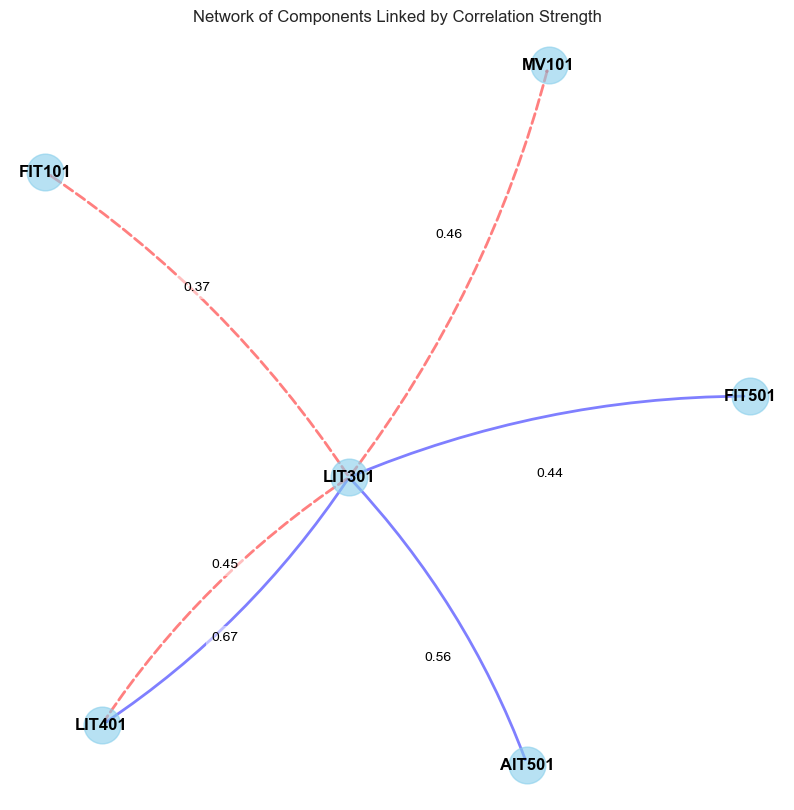

In [21]:
plot_correlation_network(components['LIT301'], top_n_corrs= 3)

## Compare Two Components Linear & Non-Linear Correlations

In [22]:
linear_corr_dict_1 = components['LIT301'].get_strongest_correlated_components('linear', top_n_corrs =4)
non_linear_corr_dict_1 = components['LIT301'].get_strongest_correlated_components('non_linear', top_n_corrs =4)
linear_corr_dict_2 = components['LIT401'].get_strongest_correlated_components('linear', top_n_corrs =4)
non_linear_corr_dict_2 = components['LIT401'].get_strongest_correlated_components('non_linear', top_n_corrs =4)

# Create two components
component1 = components['LIT301']
component2 = components['LIT401']

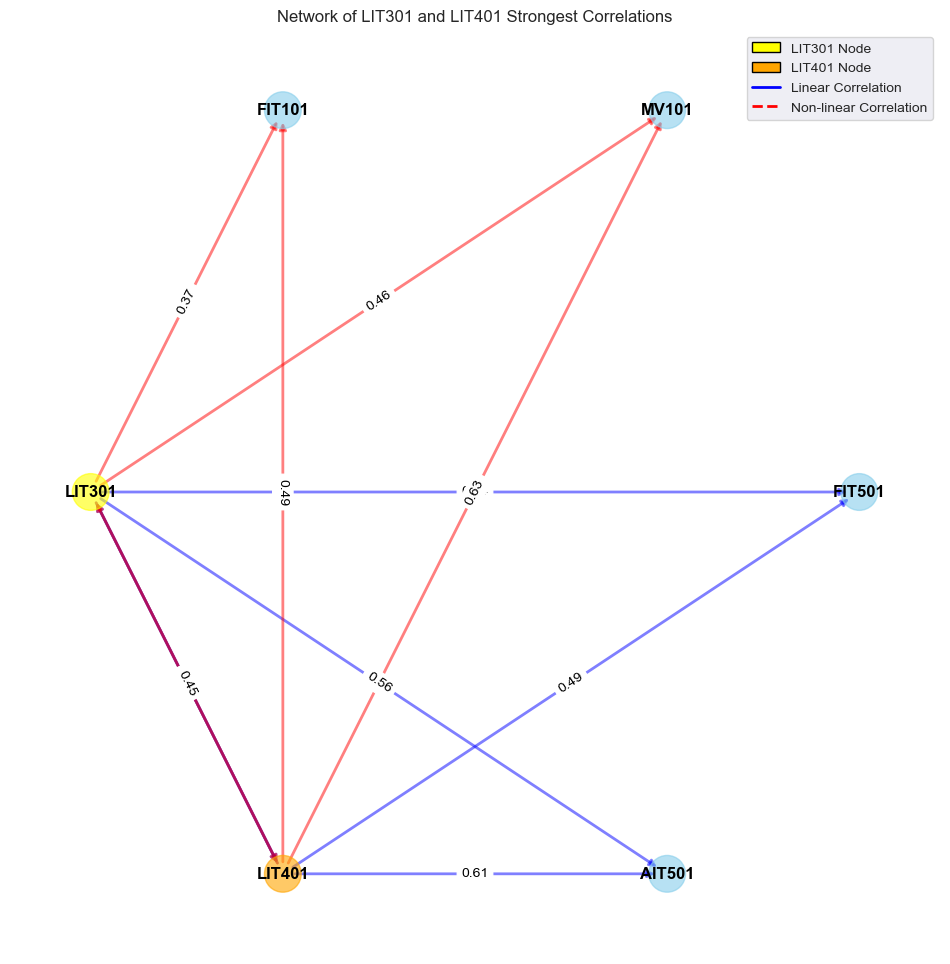

In [23]:
# Plot comparison network for both components
plot_component_comparison(component1 ,component2, linear_corr_dict_1, non_linear_corr_dict_1, linear_corr_dict_2, non_linear_corr_dict_2, top_n_corrs=3, layout= nx.shell_layout)

## Observations
P value ( statistical significance) value of 5% indicates 38 of 39 components disprove the null hypothesis that the relationship between components is random. This numebr of related components is acheived by using a Pearson correlation coefficient 0f 0.01 or above ( a very week linear correlation).
These Values were calculated from the correlation from the LIT101 water level sensor which is the main water tank at the beginning of the process ( and so is understandably linked to all other components to some degree.
Restricted the results to correlation coefficients above 0.6 identifies 5 componnets with strong correlations, all of which are in the same or following stage and are related to the movement of water ( pumps or flow sensors). This suggests the Pearson values are more useful is revelaing system dependencies.


# Kernel Distributions

Get distributions for each variable. Get range, divide into 100 bins then count variables ineach. Visualise in plot

Sample df as 10 second mean for all values so df is 10% of original to east manipulation

In [24]:
#df['LIT101']

Var Range:  696.22615


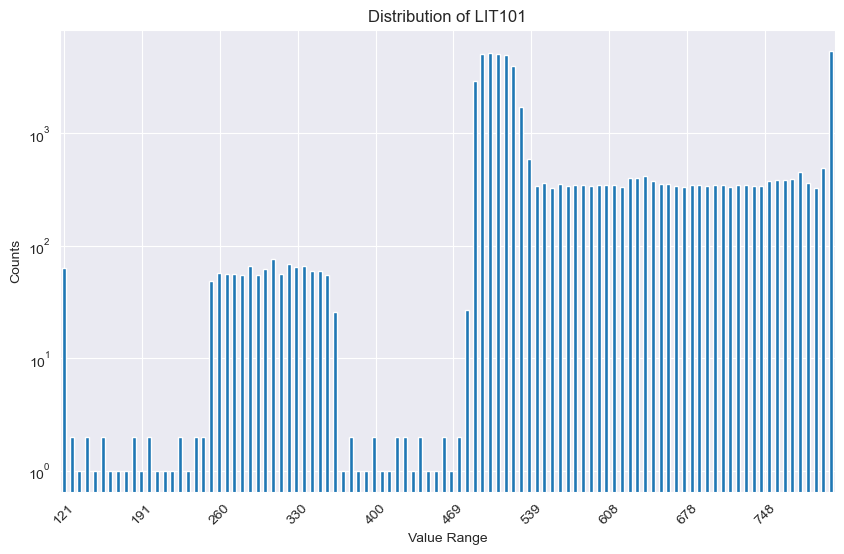

In [25]:
# test with FIT101
#lit101_dist, bins = getDistribution('LIT101')
#plotBinCounts(lit101_dist, bins)

getDistributionBins(df, 'LIT101')

<>:1: SyntaxWarning: invalid escape sequence '\G'
<>:1: SyntaxWarning: invalid escape sequence '\G'
C:\Users\loz\AppData\Local\Temp\ipykernel_11212\923483889.py:1: SyntaxWarning: invalid escape sequence '\G'
  getKDEDensity(df, 'LIT101', save_path='D:\GitHub\MSc-Project-March\Write_Up\Charts\lit_101_kde_plot.jpeg')


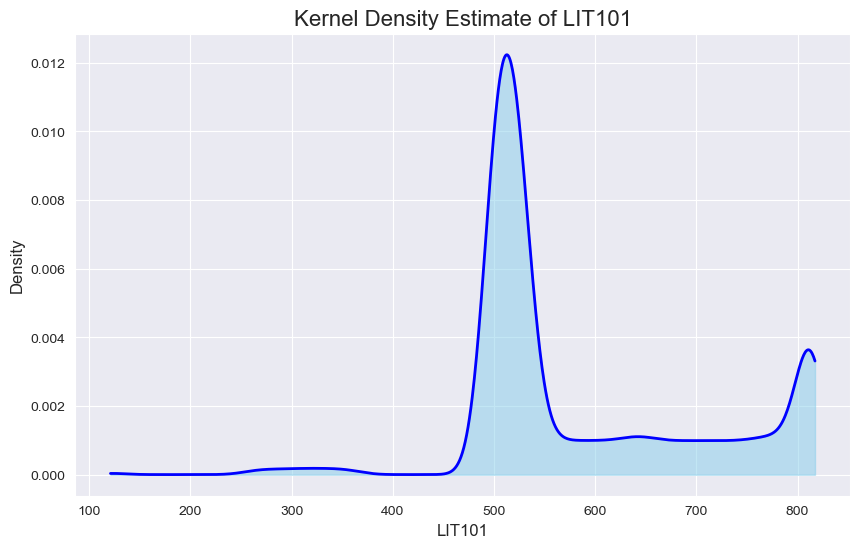

In [26]:
getKDEDensity(df, 'LIT101', save_path='D:\GitHub\MSc-Project-March\Write_Up\Charts\lit_101_kde_plot.jpeg')

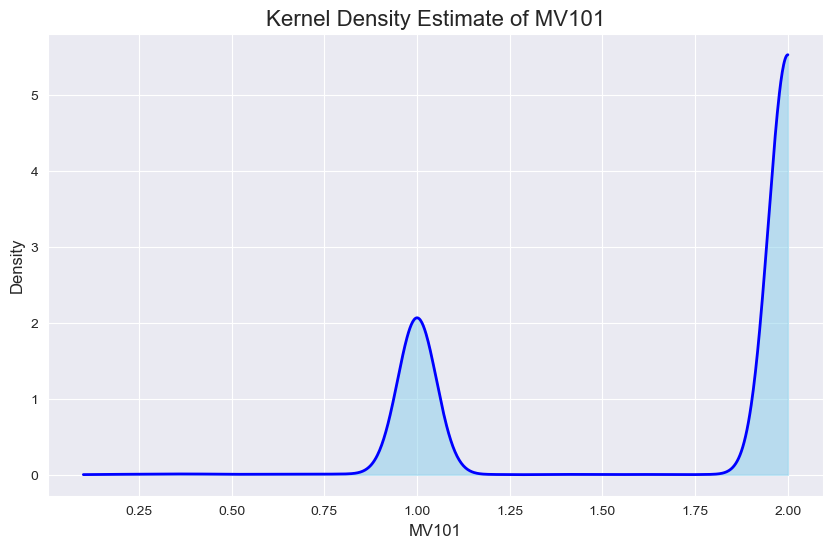

In [27]:
getKDEDensity(df, 'MV101')

# Calculate mutual information between features
mutual_info_matrix = pd.DataFrame(index=df.columns, columns=df.columns)

# Calculate mutual information
for col1 in df.columns:
    for col2 in df.columns:
        mutual_info = mutual_info_regression(df[[col1]], df[col2])[0]
        mutual_info_matrix.loc[col1, col2] = mutual_info

# Display the mutual information matrix
print(mutual_info_matrix)


In [28]:
scaler = StandardScaler()
df_normalised = scaler.fit_transform(df)
# convert back to df
df_normalised = pd.DataFrame(df_normalised, columns=df.columns)

In [30]:
#mi_lit101 = kde_mutual_information(df_normalised, 'LIT101', num_points=100, n_jobs=-1)
#print(mi_lit101)

# slow so son't re-run. Import df instead

mi_results_df = pd.DataFrame()
for component_name, component_obj in components.items():

    try:
        mi_results = kde_mutual_information(df_normalised, component_name, num_points=100, n_jobs=-1)
        mi_results_df[component_name] = mi_results
    except Exception as e:
        # In case of error, add a column of NaNs
        mi_results_df[component_name] = np.nan
        print(f"Error calculating MI for {component_name}: {e}")

    print(f"Finished:{component_name}")

# Transpose the result to make each row represent a component and each column an MI score
mi_results_df = mi_results_df.T

# Fill any missing values (optional, this step is already handled)
mi_results_df.fillna(np.nan, inplace=True)

# Print the final DataFrame
print(mi_results_df)

In [31]:
mi_results_df.to_csv('D:\GitHub\MSc-Project-March\SWaT Data\mi_results.csv', index=False)

<>:1: SyntaxWarning: invalid escape sequence '\G'
<>:1: SyntaxWarning: invalid escape sequence '\G'
C:\Users\loz\AppData\Local\Temp\ipykernel_11212\2230563796.py:1: SyntaxWarning: invalid escape sequence '\G'
  mi_results_df.to_csv('D:\GitHub\MSc-Project-March\SWaT Data\mi_results.csv', index=False)
C:\Users\loz\AppData\Local\Temp\ipykernel_11212\2230563796.py:1: SyntaxWarning: invalid escape sequence '\G'
  mi_results_df.to_csv('D:\GitHub\MSc-Project-March\SWaT Data\mi_results.csv', index=False)


NameError: name 'mi_results_df' is not defined

In [32]:
components

{'FIT101': <component_module.Component at 0x14c21a7c800>,
 'LIT101': <component_module.Component at 0x14c2181e5a0>,
 'MV101': <component_module.Component at 0x14c215454c0>,
 'P101': <component_module.Component at 0x14c21545400>,
 'AIT201': <component_module.Component at 0x14c21a0b0e0>,
 'AIT202': <component_module.Component at 0x14c21a21430>,
 'AIT203': <component_module.Component at 0x14c21b75dc0>,
 'FIT201': <component_module.Component at 0x14c21b74110>,
 'MV201': <component_module.Component at 0x14c21b76330>,
 'P203': <component_module.Component at 0x14c21b75b50>,
 'P205': <component_module.Component at 0x14c21b74a70>,
 'DPIT301': <component_module.Component at 0x14c21b770e0>,
 'FIT301': <component_module.Component at 0x14c21b75250>,
 'LIT301': <component_module.Component at 0x14c21b77110>,
 'MV301': <component_module.Component at 0x14c21b74fe0>,
 'MV302': <component_module.Component at 0x14c21b772f0>,
 'MV303': <component_module.Component at 0x14c21b74f50>,
 'MV304': <component_mod

In [34]:
mi_results_df = pd.read_csv('D:\GitHub\MSc-Project-March\SWaT Data\mi_results.csv')

<>:1: SyntaxWarning: invalid escape sequence '\G'
<>:1: SyntaxWarning: invalid escape sequence '\G'
C:\Users\loz\AppData\Local\Temp\ipykernel_11212\797737294.py:1: SyntaxWarning: invalid escape sequence '\G'
  mi_results_df = pd.read_csv('D:\GitHub\MSc-Project-March\SWaT Data\mi_results.csv')


In [35]:
mi_results_df.rename(columns={'Unnamed: 0':'Component'}, inplace=True)
mi_results_df.set_index('Component', inplace=True)
mi_results_df.index

In [40]:
for component_name, component in components.items():
    if component_name in mi_results_df.columns:
        component.mutual_info_dict = mi_results_df[component_name]
    else:
        component.mutual_info_dict = {}


In [43]:
components.keys()

dict_keys(['FIT101', 'LIT101', 'MV101', 'P101', 'AIT201', 'AIT202', 'AIT203', 'FIT201', 'MV201', 'P203', 'P205', 'DPIT301', 'FIT301', 'LIT301', 'MV301', 'MV302', 'MV303', 'MV304', 'P301', 'P302', 'AIT401', 'AIT402', 'FIT401', 'LIT401', 'P402', 'UV401', 'AIT501', 'AIT502', 'AIT503', 'AIT504', 'FIT501', 'FIT502', 'FIT503', 'FIT504', 'P501', 'PIT501', 'PIT502', 'PIT503', 'FIT601', 'P602'])

In [44]:
components['P301'].get_mutual_info()

{'P301': nan,
 'P402': inf,
 'UV401': inf,
 'P501': inf,
 'PIT503': inf,
 'MV303': 123.90113482703184,
 'LIT101': 119.48652422746972,
 'AIT503': 85.38288021695622,
 'MV304': 76.96289110870697,
 'PIT502': 60.43273129931946,
 'MV101': 48.32396077724568,
 'AIT201': 48.253455236948696,
 'MV301': 41.533410866856585,
 'MV201': 33.47690899379686,
 'MV302': 29.79166479493874,
 'AIT402': 29.408785517423592,
 'FIT502': 28.11599063187585,
 'PIT501': 27.996776339867584,
 'AIT502': 27.63793407406125,
 'AIT202': 26.69144592625172,
 'AIT203': 25.774797875341,
 'AIT501': 23.515454317415102,
 'LIT401': 23.30716758059141,
 'FIT503': 22.121543491394217,
 'LIT301': 21.94031652172271,
 'DPIT301': 21.79165189722752,
 'FIT504': 17.97722938675739,
 'FIT301': 17.78394210219206,
 'FIT501': 17.008178794907327,
 'FIT401': 16.993063916788,
 'FIT101': 16.36173087731406,
 'P302': 15.763809192442624,
 'FIT201': 15.643522670731691,
 'AIT401': 15.374563299673028,
 'P101': 15.101903865185344,
 'P203': 15.100789862245785

In [ ]:
#type(mi_results)
mi_sorted = mi_lit101.sort_values(ascending=False)

In [ ]:
print(mi_sorted.iloc[:20])

1,FIT-101,Sensor,Flow meter; Measures inflow into raw water tank.
2,LIT-101,Sensor,Level Transmitter; Raw water tank level.
3,MV-101,Actuator,Motorized valve; Controls water flow to the raw water tank.

In [ ]:
getDistribution('MV101')

In [ ]:
getDistribution('FIT101')

In [ ]:
getDistribution('P101')

# Create masks for Spearman and Mutual Information correlations higher than Pearson

This could identify componets such as switches which are strongly correlated but non-linear and would be missed in linear only analysis

In [ ]:
# Create masks for Spearman and Mutual Information correlations higher than Pearson
spearman_higher_mask = non_lin_correlation_matrix > correlation_matrix
#mutual_info_higher_mask = mutual_info_matrix > correlation_matrix

# Extract values where Spearman correlation is higher than Pearson
spearman_higher_values = non_lin_correlation_matrix[spearman_higher_mask]

# Extract values where Mutual Information correlation is higher than Pearson
# needs to be cahnged to ranked value
#mutual_info_higher_values = mutual_info_matrix[mutual_info_higher_mask]

# Combine the extracted values
#higher_values = pd.concat([spearman_higher_values, mutual_info_higher_values])

# Plot the higher values
plt.figure(figsize=(10, 6))
sns.barplot(x=higher_values.index, y=higher_values.values, palette='coolwarm')
plt.title('Values where Spearman or Mutual Info are higher than Pearson')
plt.xlabel('Component Pair')
plt.ylabel('Correlation Value')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# Dim Reduction of Corr Matrix

In [ ]:
# Calculate the linear correlation matrix
correlation_matrix = df.corr().round(decimals= 4)

In [ ]:
correlation_matrix = correlation_matrix.drop(columns = 'Correlation Type')

In [ ]:
correlation_matrix.

In [ ]:
cluster_labels

In [ ]:
reduced_data

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Step 2: Apply Agglomerative Clustering
# Perform hierarchical clustering
agg_cluster = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')
cluster_labels = agg_cluster.fit_predict(correlation_matrix)

# Step 2: Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(correlation_matrix)

# Step 3: Plot the results
plt.figure(figsize=(10, 8))
# Use different colors for different clusters
colors = ['red', 'green', 'blue']
for i in range(len(reduced_data)):
    plt.scatter(reduced_data[i, 0], reduced_data[i, 1],
                color=colors[cluster_labels[i]], label=f'Cluster {cluster_labels[i]}' if i == 0 else "", s=100)
    plt.text(reduced_data[i, 0], reduced_data[i, 1], correlation_matrix.columns[i], fontsize=12)

plt.title('2D PCA of Correlation Matrix with Agglomerative Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from mpl_toolkits.mplot3d import Axes3D

# Example correlation matrix (replace with your actual correlation matrix)
np.random.seed(0)

# Step 1: Standardize the correlation matrix (optional but often recommended)
#scaler = StandardScaler()
#correlation_matrix_scaled = scaler.fit_transform(correlation_matrix)



# Step 3: Apply PCA to reduce to 3 dimensions
pca = PCA(n_components=6)
reduced_data = pca.fit_transform(correlation_matrix)

# Step 2: Apply Agglomerative Clustering
agg_cluster = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')
cluster_labels = agg_cluster.fit_predict(reduced_data)


# Step 3: Create a DataFrame to show which variables belong to which cluster
cluster_df = pd.DataFrame({
    'Variable': correlation_matrix.columns,
    'Cluster': cluster_labels
})

grouped = cluster_df_sorted.groupby(by='Cluster')['Variable'].apply(list)
grouped




In [ ]:
# Display the grouped components by cluster and forast for latex

# Latex table code
latex_table = "\\begin{table}[h!]\n\\centering\n\\begin{tabular}{|c|l|c|}\n\\hline\n"
latex_table += "Cluster & Components & No. Components \\\\\n\\hline\n"

for cluster, components in clusters.items():
    # Split components into lines with a max of 10 components per line
    component_lines = [', '.join(components[i:i+10]) for i in range(0, len(components), 10)]
    component_str = ' \\\\ '.join(component_lines)
    latex_table += f"{cluster} & {component_str}  \\\\\n"

latex_table += "\\hline\n\\end{tabular}\n\\caption{Clustered Components}\n\\label{tab:clusters}\n\\end{table}"

print(latex_table)

In [ ]:
agg_cluster

In [ ]:
# Step 2: Apply Agglomerative Clustering
agg_cluster = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')
cluster_labels = agg_cluster.fit_predict(correlation_matrix)

# Step 3: Create a DataFrame to show which variables belong to which cluster
cluster_df = pd.DataFrame({
    'Variable': correlation_matrix.columns,
    'Cluster': cluster_labels
})

# Step 4: Sort by cluster for better readability
cluster_df_sorted = cluster_df.sort_values(by='Cluster').reset_index(drop=True)

# Display the DataFrame
print(cluster_df_sorted)

In [ ]:
# Step 3: Create a DataFrame to show which variables belong to which cluster
cluster_df = pd.DataFrame({
    'Variable': correlation_matrix.columns,
    'Cluster': cluster_labels
})

grouped = cluster_df_sorted.groupby(by='Cluster')['Variable'].apply(list)
grouped

In [ ]:
type(cluster_df_sorted)

In [ ]:
print(cluster_df_sorted.groupby('Cluster'))

In [ ]:
from sklearn.decomposition import FactorAnalysis

# Assuming 'data' is your original dataset
fa = FactorAnalysis(n_components=6)  # You can choose the number of factors
fa.fit(correlation_matrix)

# Transformed data with reduced dimensions
transformed_data = fa.transform(correlation_matrix)

In [ ]:
transformed_data